In [ ]:
import os
import time
import copy
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')
# reproducibilidad
torch.manual_seed(42)
np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda"

In [ ]:
# Tamaño de cada lote (batch) que se usará durante el entrenamiento.
batch_size = 128

# Número de procesos en paralelo para cargar datos.
num_workers = 2

# Carpeta donde se guardarán/descargarán los datos CIFAR-10.
data_dir = "/content/data"


In [ ]:
transform_train = transforms.Compose([
    # Cambia el tamaño original de CIFAR-10 (32x32) a 224x224, requerido por AlexNet.
    transforms.Resize((224, 224)),

    # Aumento de datos: voltea horizontalmente algunas imágenes aleatoriamente.
    transforms.RandomHorizontalFlip(),

    # Convierte la imagen de PIL a un tensor.
    transforms.ToTensor(),

    # Normaliza la imagen con la media y desviación estándar de ImageNet,
    # porque AlexNet fue entrenada con estos valores.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    # Igual que en entrenamiento: ajustar tamaño.
    transforms.Resize((224, 224)),

    # Convierte a tensor.
    transforms.ToTensor(),

    # Normalización igual a la del entrenamiento.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset de entrenamiento, con descarga automática y las transformaciones definidas.
trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
# Dataset de prueba, también descargado en la misma carpeta.
testset  = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# DataLoader para entrenamiento: mezcla los datos (shuffle=True) en cada epoch.
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
# DataLoader para prueba: no se mezclan los datos (shuffle=False).
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Lista de nombres de las 10 clases de CIFAR-10 (avion, perro, rana, etc.)
class_names = trainset.classes
print("Clases:", class_names)
# Muestra cuántas imágenes hay en entrenamiento y prueba.
print("Tamaño train:", len(trainset), "tamaño test:", len(testset))

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Tamaño train: 50000 tamaño test: 10000


In [ ]:
# Definimos la clase AlexNet heredando de nn.Module
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Bloque de extracción de características
        self.features = nn.Sequential(

            # Primera capa convolucional:
            # - Entrada: 3 canales RGB
            # - Salida: 64 filtros
            # - Kernel grande (11x11), stride 4 para reducir resolución rápido
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),

            # Primer max-pooling para reducir tamaño espacial
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Segunda capa convolucional
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            # Segundo pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Tercera capa conv (kernel 3x3)
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Cuarta capa conv
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Quinta capa conv
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Último max-pool para terminar extracción espacial
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Clasificador completamente conectado (fully connected)
        self.classifier = nn.Sequential(
            nn.Dropout(),  # Dropout para evitar overfitting

            # Capa totalmente conectada:
            # - Entrada: 256*6*6 (tamaño esperado después de convoluciones con input 224x224)
            # - Salida: 4096 neuronas
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),  # Otro dropout

            # Segunda capa FC grande
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            # Última capa: salida con tantas clases como CIFAR-10
            nn.Linear(4096, num_classes),
        )

    # Definimos el paso hacia adelante
    def forward(self, x):
        x = self.features(x)       # Pasamos por convoluciones
        x = torch.flatten(x, 1)    # Aplanamos tensor para la red totalmente conectada
        x = self.classifier(x)     # Pasamos por el clasificador
        return x

# Crear modelo con el número de clases del dataset cargado
model = AlexNet(num_classes=len(class_names)).to(device)

# Mostrar arquitectura del modelo
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [ ]:
# Definimos la función de pérdida (loss function)
# CrossEntropyLoss es la más común para clasificación multiclase.
criterion = nn.CrossEntropyLoss()

# Definimos el optimizador
# - SGD: Gradiente estocástico
# - lr=0.01: tasa de aprendizaje inicial
# - momentum=0.9: ayuda a suavizar y acelerar el descenso
# - weight_decay=5e-4: regularización L2 para evitar overfitting
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Scheduler para reducir la tasa de aprendizaje durante el entrenamiento
# StepLR disminuye lr multiplicándolo por gamma cada "step_size" epochs.
# Aquí:
# - Cada 10 épocas lr → lr * 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Imprimimos configuración del optimizador (solo para ver los valores actuales)
print("Optimizer:", optimizer)

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    # Ponemos el modelo en modo entrenamiento (activa dropout, batchnorm, etc.)
    model.train()

    # Acumuladores para estadísticas de la época
    running_loss = 0.0
    correct = 0
    total = 0

    # Iteramos sobre el dataloader (batch por batch)
    for inputs, targets in tqdm(loader, leave=False):
        # Movemos los datos a GPU/CPU según el device seleccionado
        inputs, targets = inputs.to(device), targets.to(device)

        # Reiniciamos gradientes acumulados de la iteración anterior
        optimizer.zero_grad()

        # Forward: pasamos las imágenes por el modelo para obtener predicciones
        outputs = model(inputs)

        # Calculamos la pérdida entre predicción y etiqueta real
        loss = criterion(outputs, targets)

        # Backpropagation: calculamos los gradientes
        loss.backward()

        # Actualizamos los pesos del modelo con los gradientes calculados
        optimizer.step()

        # Guardamos la pérdida multiplicada por el tamaño del batch
        running_loss += loss.item() * inputs.size(0)

        # Obtenemos la clase con mayor probabilidad para cada imagen
        _, preds = outputs.max(1)

        # Contamos cuántas predicciones fueron correctas
        correct += preds.eq(targets).sum().item()

        # Contamos cuántos ejemplos totales van procesados
        total += inputs.size(0)

    # Calculamos pérdida promedio de la época
    epoch_loss = running_loss / total

    # Calculamos precisión (accuracy)
    epoch_acc = correct / total

    # Devolvemos métricas de entrenamiento
    return epoch_loss, epoch_acc


In [ ]:
def eval_model(model, loader, criterion, device):
    # Ponemos el modelo en modo evaluación (desactiva dropout)
    model.eval()

    # Acumuladores para estadísticas
    running_loss = 0.0
    correct = 0
    total = 0

    # No calculamos gradientes → más rápido y menos memoria
    with torch.no_grad():
        for inputs, targets in tqdm(loader, leave=False):
            # Movemos datos al device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward: obtenemos predicciones
            outputs = model(inputs)

            # Calculamos pérdida
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            # Obtenemos clase predicha
            _, preds = outputs.max(1)

            # Contamos correctos
            correct += preds.eq(targets).sum().item()

            # Contamos total de ejemplos
            total += inputs.size(0)

    # Pérdida promedio de test
    epoch_loss = running_loss / total

    # Precisión en validación/test
    epoch_acc = correct / total

    # Retornamos métricas de evaluación
    return epoch_loss, epoch_acc


In [ ]:
# Número total de épocas de entrenamiento
num_epochs = 25

# Guardamos una copia inicial de los pesos del modelo
# Para luego poder recuperar el mejor modelo (early-better)
best_model_wts = copy.deepcopy(model.state_dict())

# Accuracy máximo alcanzado durante validación
best_acc = 0.0

# Historial para graficar o analizar después
train_hist = []   # lista de (loss, acc) por época
val_hist = []     # lista de (loss, acc) por época

for epoch in range(num_epochs):

    # Medimos tiempo por época
    start = time.time()

    # ENTRENAMIENTO en la época actual
    train_loss, train_acc = train_one_epoch(
        model, trainloader, criterion, optimizer, device
    )

    # EVALUACIÓN en test/validación
    val_loss, val_acc = eval_model(
        model, testloader, criterion, device
    )

    # Actualizamos el scheduler
    scheduler.step()

    # Guardamos métricas para análisis posterior
    train_hist.append((train_loss, train_acc))
    val_hist.append((val_loss, val_acc))

    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        # Copiamos los mejores pesos
        best_model_wts = copy.deepcopy(model.state_dict())

    # Tiempo total de la época
    elapsed = time.time() - start

    # Imprimimos resumen
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train loss: {train_loss:.4f} acc: {train_acc:.4f}  |  "
          f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}  |  "
          f"time: {elapsed:.1f}s")

# Al final del entrenamiento cargamos los mejores pesos encontrados
model.load_state_dict(best_model_wts)
print("Mejor accuracy en validación:", best_acc)


Epoch [1/25]  Train loss: 2.0359 acc: 0.2367  |  Val loss: 1.6566 acc: 0.3884  |  time: 131.6s


Epoch [2/25]  Train loss: 1.4544 acc: 0.4653  |  Val loss: 1.2776 acc: 0.5435  |  time: 127.3s


Epoch [3/25]  Train loss: 1.1357 acc: 0.5929  |  Val loss: 0.9948 acc: 0.6481  |  time: 119.0s


Epoch [4/25]  Train loss: 0.9239 acc: 0.6760  |  Val loss: 0.7930 acc: 0.7224  |  time: 135.3s


Epoch [5/25]  Train loss: 0.7971 acc: 0.7223  |  Val loss: 0.7413 acc: 0.7422  |  time: 128.1s


Epoch [6/25]  Train loss: 0.6849 acc: 0.7618  |  Val loss: 0.6552 acc: 0.7759  |  time: 120.8s


Epoch [7/25]  Train loss: 0.6191 acc: 0.7852  |  Val loss: 0.6241 acc: 0.7885  |  time: 121.2s


Epoch [8/25]  Train loss: 0.5609 acc: 0.8057  |  Val loss: 0.5682 acc: 0.8087  |  time: 119.6s


Epoch [9/25]  Train loss: 0.5218 acc: 0.8203  |  Val loss: 0.5908 acc: 0.7999  |  time: 120.0s


Epoch [10/25]  Train loss: 0.4730 acc: 0.8367  |  Val loss: 0.5313 acc: 0.8208  |  time: 128.3s


Epoch [11/25]  Train loss: 0.3316 acc: 0.8858  |  Val loss: 0.4447 acc: 0.8506  |  time: 120.6s


Epoch [12/25]  Train loss: 0.2995 acc: 0.8961  |  Val loss: 0.4355 acc: 0.8579  |  time: 120.3s


Epoch [13/25]  Train loss: 0.2776 acc: 0.9044  |  Val loss: 0.4282 acc: 0.8595  |  time: 117.4s


Epoch [14/25]  Train loss: 0.2704 acc: 0.9083  |  Val loss: 0.4305 acc: 0.8604  |  time: 119.0s


Epoch [15/25]  Train loss: 0.2569 acc: 0.9124  |  Val loss: 0.4215 acc: 0.8636  |  time: 117.6s


Epoch [16/25]  Train loss: 0.2486 acc: 0.9150  |  Val loss: 0.4220 acc: 0.8652  |  time: 117.6s


Epoch [17/25]  Train loss: 0.2401 acc: 0.9170  |  Val loss: 0.4219 acc: 0.8648  |  time: 119.2s


Epoch [18/25]  Train loss: 0.2318 acc: 0.9215  |  Val loss: 0.4189 acc: 0.8654  |  time: 117.1s


Epoch [19/25]  Train loss: 0.2198 acc: 0.9241  |  Val loss: 0.4237 acc: 0.8680  |  time: 118.4s


Epoch [20/25]  Train loss: 0.2126 acc: 0.9272  |  Val loss: 0.4151 acc: 0.8682  |  time: 117.8s


Epoch [21/25]  Train loss: 0.1963 acc: 0.9337  |  Val loss: 0.4163 acc: 0.8696  |  time: 116.5s


Epoch [22/25]  Train loss: 0.1924 acc: 0.9343  |  Val loss: 0.4169 acc: 0.8712  |  time: 118.5s


Epoch [23/25]  Train loss: 0.1896 acc: 0.9351  |  Val loss: 0.4177 acc: 0.8708  |  time: 118.0s


Epoch [24/25]  Train loss: 0.1893 acc: 0.9363  |  Val loss: 0.4183 acc: 0.8714  |  time: 116.8s


Epoch [25/25]  Train loss: 0.1857 acc: 0.9378  |  Val loss: 0.4186 acc: 0.8704  |  time: 118.7s
Mejor accuracy en validación: 0.8714


In [ ]:
# Ponemos el modelo en modo evaluación (desactiva dropout, etc.)
model.eval()

# Listas donde iremos guardando todas las predicciones y etiquetas reales
all_preds = []
all_targets = []

with torch.no_grad():
    # Recorremos todo el conjunto de test
    for inputs, targets in tqdm(testloader, leave=False):

        # Movemos las imágenes al device
        inputs = inputs.to(device)

        # Hacemos forward para obtener los logits predichos
        outputs = model(inputs)

        # Tomamos la clase con mayor probabilidad
        _, preds = outputs.max(1)

        # Guardamos predicciones y etiquetas en listas de Python (convertidas a CPU)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.numpy())


# classification_report muestra:
# - precisión por clase (precision)
# - sensibilidad o recall
# - F1-score
# - soporte (# de ejemplos por clase)
print(classification_report(all_targets, all_preds, target_names=class_names))


# Matriz NxN donde N = número de clases
# cm[i][j] = imágenes de clase i clasificadas como clase j
cm = confusion_matrix(all_targets, all_preds)


              precision    recall  f1-score   support

    airplane       0.87      0.88      0.88      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.86      0.79      0.82      1000
         cat       0.74      0.76      0.75      1000
        deer       0.84      0.87      0.85      1000
         dog       0.82      0.80      0.81      1000
        frog       0.91      0.91      0.91      1000
       horse       0.91      0.91      0.91      1000
        ship       0.93      0.93      0.93      1000
       truck       0.90      0.93      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



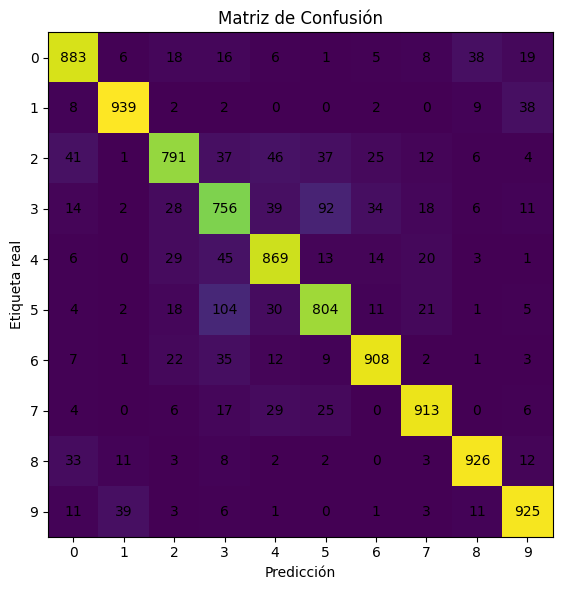

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm)

ax.set_title("Matriz de Confusión")
ax.set_xlabel("Predicción")
ax.set_ylabel("Etiqueta real")

# Mostrar todas las marcas de verificación
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(302.5), np.float64(218.5), np.float64(-0.5))

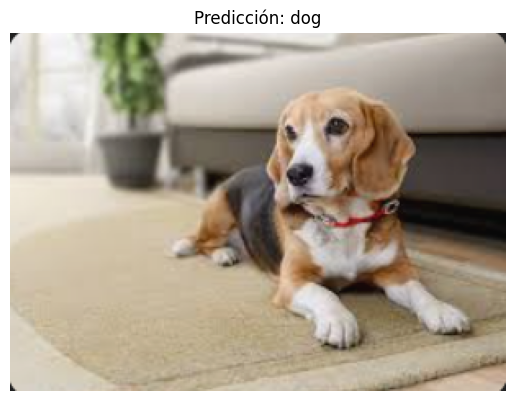

In [ ]:
# ejemplo
from PIL import Image

def predict_image(img_path, model, transform, device, class_names):
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
        _, pred = out.max(1)
    return pred.item(), img

uploaded_path = "/content/drive/My Drive/Colab Notebooks/perro.png"
pred_label, img = predict_image(uploaded_path, model, transform_test, device, class_names)
plt.imshow(img); plt.title(f"Predicción: {class_names[pred_label]}"); plt.axis('off')


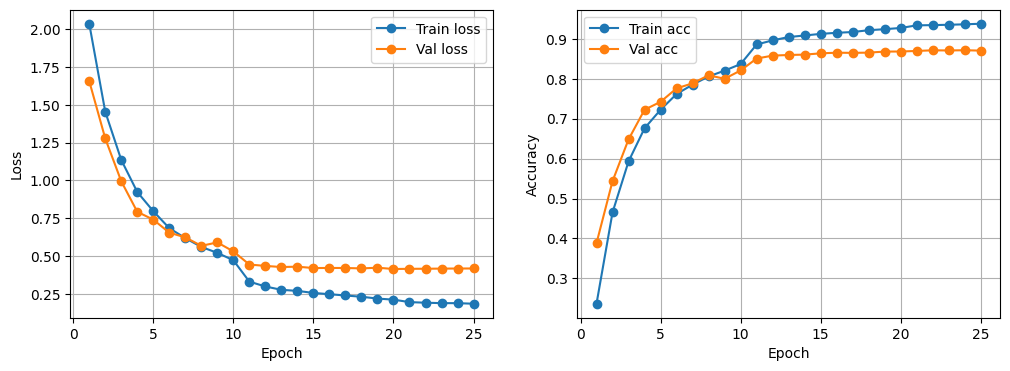

In [ ]:
train_losses = [t[0] for t in train_hist]
train_accs   = [t[1] for t in train_hist]
val_losses   = [v[0] for v in val_hist]
val_accs     = [v[1] for v in val_hist]

epochs = np.arange(1, len(train_losses)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'o-', label='Train loss')
plt.plot(epochs, val_losses,   'o-', label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'o-', label='Train acc')
plt.plot(epochs, val_accs,   'o-', label='Val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.show()
